In [1]:
!unzip netflix-report.zip

Archive:  netflix-report.zip
   creating: netflix-report/
   creating: netflix-report/MESSAGES/
  inflating: netflix-report/MESSAGES/MessagesSentByNetflix.csv  
   creating: __MACOSX/
   creating: __MACOSX/netflix-report/
   creating: __MACOSX/netflix-report/MESSAGES/
  inflating: __MACOSX/netflix-report/MESSAGES/._MessagesSentByNetflix.csv  
  inflating: __MACOSX/netflix-report/._MESSAGES  
   creating: netflix-report/CONTENT_INTERACTION/
  inflating: netflix-report/CONTENT_INTERACTION/IndicatedPreferences.csv  
   creating: __MACOSX/netflix-report/CONTENT_INTERACTION/
  inflating: __MACOSX/netflix-report/CONTENT_INTERACTION/._IndicatedPreferences.csv  
  inflating: netflix-report/CONTENT_INTERACTION/.DS_Store  
  inflating: __MACOSX/netflix-report/CONTENT_INTERACTION/._.DS_Store  
  inflating: netflix-report/CONTENT_INTERACTION/MyList.csv  
  inflating: __MACOSX/netflix-report/CONTENT_INTERACTION/._MyList.csv  
  inflating: netflix-report/CONTENT_INTERACTION/Ratings.csv  
  inflating

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
devices_df = pd.read_csv('netflix-report/ACCOUNT/AccessAndDevices.csv')
clickstream_df = pd.read_csv('netflix-report/CLICKSTREAM/Clickstream.csv')
viewing_df = pd.read_csv('netflix-report/CONTENT_INTERACTION/ViewingActivity.csv', on_bad_lines='skip')
profiles_df = pd.read_csv('netflix-report/PROFILES/Profiles.csv')
device_meta_df = pd.read_csv('netflix-report/DEVICES/Devices.csv')

In [4]:
viewing_df = viewing_df[['Profile Name', 'Start Time', 'Duration', 'Device Type', 'Title']]
clickstream_df = clickstream_df[['Profile Name', 'Click Utc Ts', 'Webpage Url']]

viewing_df['Start Time'] = pd.to_datetime(viewing_df['Start Time'])
clickstream_df['Click Utc Ts'] = pd.to_datetime(clickstream_df['Click Utc Ts'])

devices_df['Date'] = pd.to_datetime(devices_df['Date'])

<ipython-input-4-e28c412732c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clickstream_df['Click Utc Ts'] = pd.to_datetime(clickstream_df['Click Utc Ts'])


In [5]:
merged = viewing_df.merge(profiles_df[['Profile Name', 'Date Of Birth']], on='Profile Name', how='left')

merged = merged.merge(device_meta_df[['Profile Name', 'Device Type', 'Profile First Playback Date']],
                      on=['Profile Name', 'Device Type'], how='left')

clickstream_df = clickstream_df.sort_values(['Profile Name', 'Click Utc Ts'])
merged = merged.sort_values(['Profile Name', 'Start Time'])

In [6]:
merged['hour'] = merged['Start Time'].dt.hour
merged['day_of_week'] = merged['Start Time'].dt.day_name()
merged['month'] = merged['Start Time'].dt.month_name()
merged['is_weekend'] = merged['day_of_week'].isin(['Saturday', 'Sunday'])

In [7]:
def to_seconds(x):
    try:
        h, m, s = x.split(':')
        return int(h)*3600 + int(m)*60 + int(s)
    except:
        return np.nan

merged['duration_sec'] = merged['Duration'].astype(str).apply(to_seconds)

merged = merged.dropna(subset=['Start Time', 'Duration', 'duration_sec'])

In [8]:
hourly = merged.groupby('hour')['duration_sec'].sum().reset_index()

user_hourly = merged.groupby(['Profile Name', 'hour'])['duration_sec'].sum().reset_index()

device_hourly = merged.groupby(['Device Type', 'hour'])['duration_sec'].sum().reset_index()

weekagg = merged.groupby('is_weekend')['duration_sec'].agg(['sum','mean','count']).reset_index()

monthly = merged.groupby('month')['duration_sec'].sum().reindex(
    ['January','February','March','April','May','June','July','August','September','October','November','December']
).dropna().reset_index()

profile_device = merged.groupby(['Profile Name','Device Type'])['duration_sec'].sum().reset_index()

user_totals = merged.groupby('Profile Name')['duration_sec'].sum().reset_index()

device_totals = merged.groupby('Device Type')['duration_sec'].sum().reset_index()

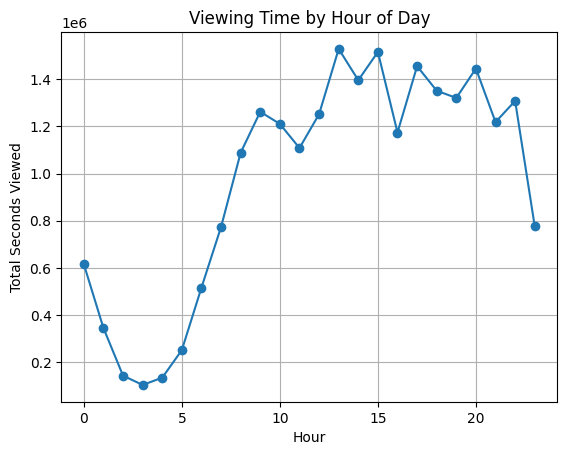

In [9]:
plt.figure()
plt.plot(hourly['hour'], hourly['duration_sec'], marker='o')
plt.title('Viewing Time by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Total Seconds Viewed')
plt.grid(True)
plt.show()

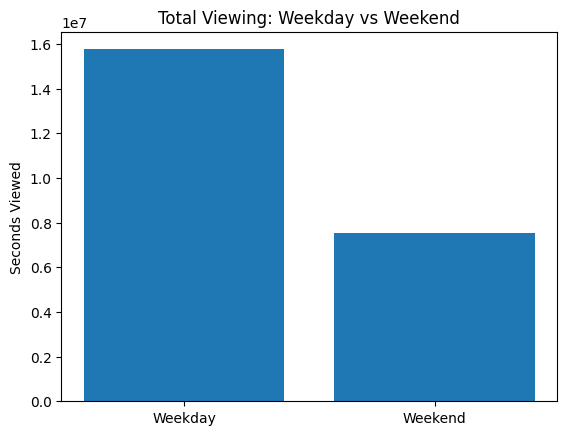

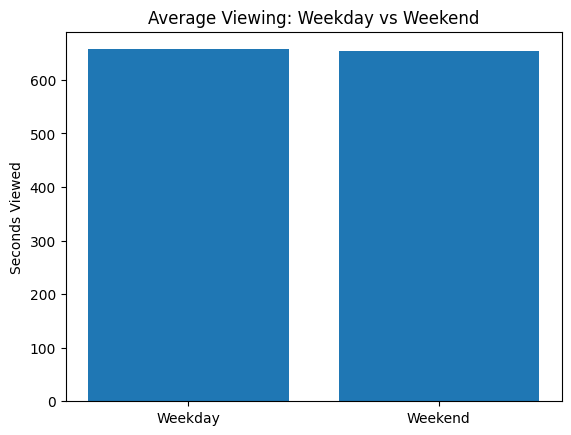

In [10]:
plt.figure()
plt.bar(['Weekday','Weekend'], weekagg['sum'])
plt.title('Total Viewing: Weekday vs Weekend')
plt.ylabel('Seconds Viewed')
plt.show()

plt.figure()
plt.bar(['Weekday','Weekend'], weekagg['mean'])
plt.title('Average Viewing: Weekday vs Weekend')
plt.ylabel('Seconds Viewed')
plt.show()

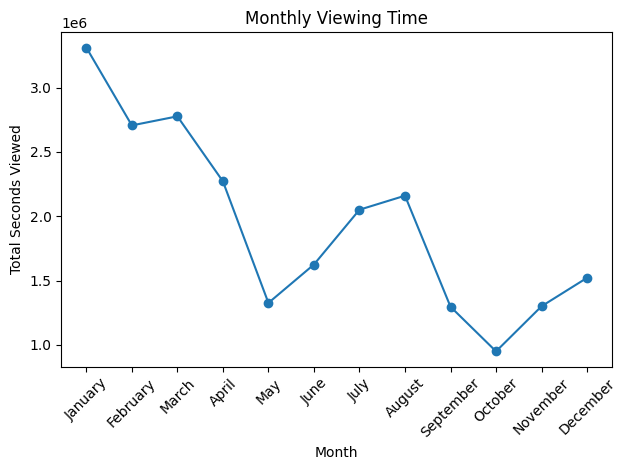

In [11]:
plt.figure()
plt.plot(monthly['month'], monthly['duration_sec'], marker='o')
plt.title('Monthly Viewing Time')
plt.xlabel('Month')
plt.ylabel('Total Seconds Viewed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

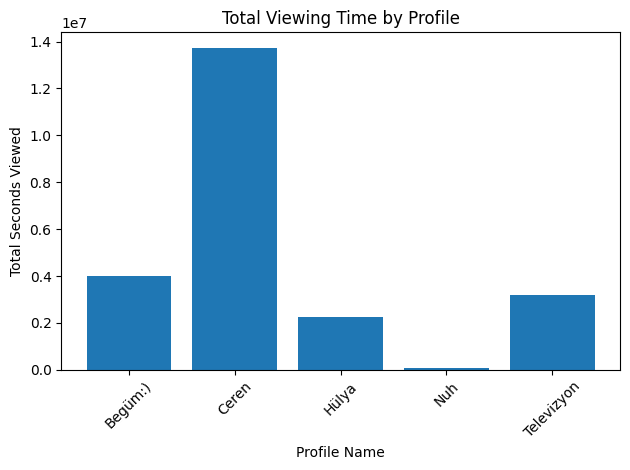

In [12]:
plt.figure()
plt.bar(
    user_totals['Profile Name'],
    user_totals['duration_sec']
)
plt.title('Total Viewing Time by Profile')
plt.xlabel('Profile Name')
plt.ylabel('Total Seconds Viewed')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

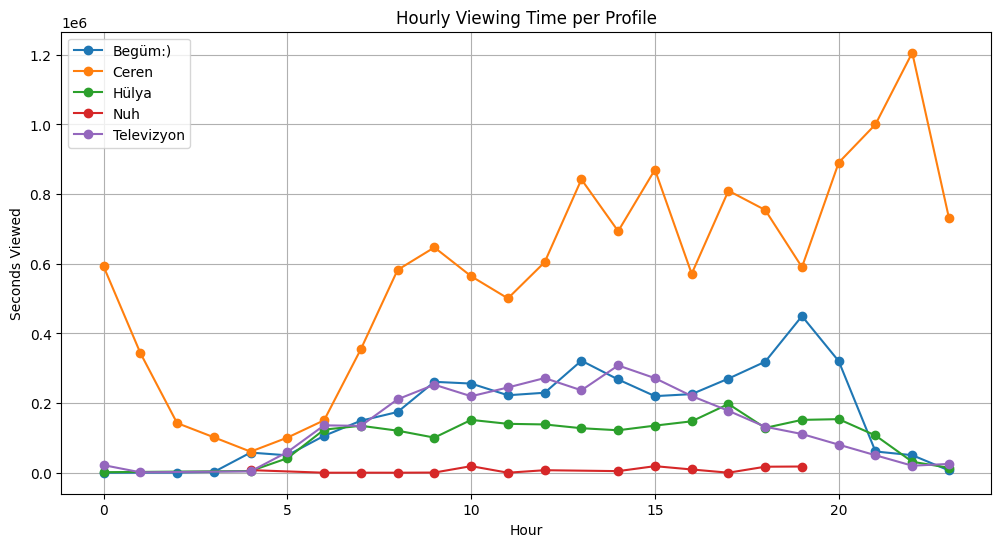

In [13]:
plt.figure(figsize=(12,6))
for name, grp in user_hourly.groupby('Profile Name'):
    plt.plot(grp['hour'], grp['duration_sec'], marker='o', label=name)
plt.title('Hourly Viewing Time per Profile')
plt.xlabel('Hour')
plt.ylabel('Seconds Viewed')
plt.legend()
plt.grid(True)
plt.show()

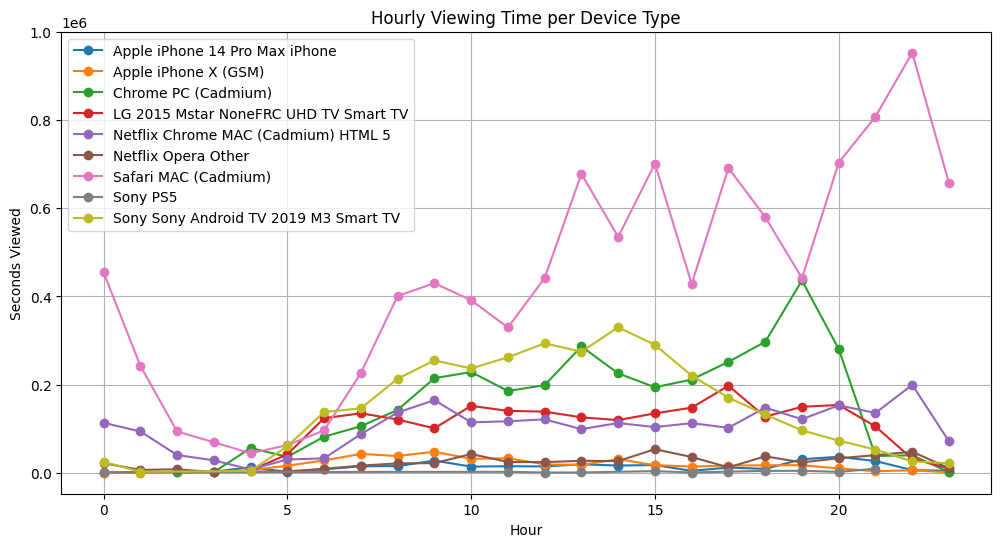

In [14]:
plt.figure(figsize=(12,6))
for dev, grp in device_hourly.groupby('Device Type'):
    plt.plot(grp['hour'], grp['duration_sec'], marker='o', label=dev)
plt.title('Hourly Viewing Time per Device Type')
plt.xlabel('Hour')
plt.ylabel('Seconds Viewed')
plt.legend()
plt.grid(True)
plt.show()